In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [26]:
files = glob.glob('../Cruise_2024/Data/FE/FeT_8.30.2024_um/*Absorbance*.txt')
files_nm = glob.glob('../Cruise_2024/Data/FE/FeT_8.30.2024_um/*nm*.txt')

#here is where the output will go 
path_save_1 = '../Cruise_2024/Data/FE/FeT_8.30.2024_um/Curve_abs.csv'
path_save_2 = '../Cruise_2024/Data/FE/FeT_8.30.2024_um/Fe2_abs.csv'
files

['../Cruise_2024/Data/FE/FeT_8.30.2024_um\\000_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\000_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\010_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\010_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\020_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\020_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\050_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\050_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\100_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\100_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\200_nm_post_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\200_nm_pre_Absorbance_00001.txt',
 '../Cruise_2024/Data/FE/FeT_8.30.2024_um\\BLANK_3_Absorbance_00001.tx

In [27]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [28]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_21148\1438546560.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wl'] = df.index


In [29]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'Iron')

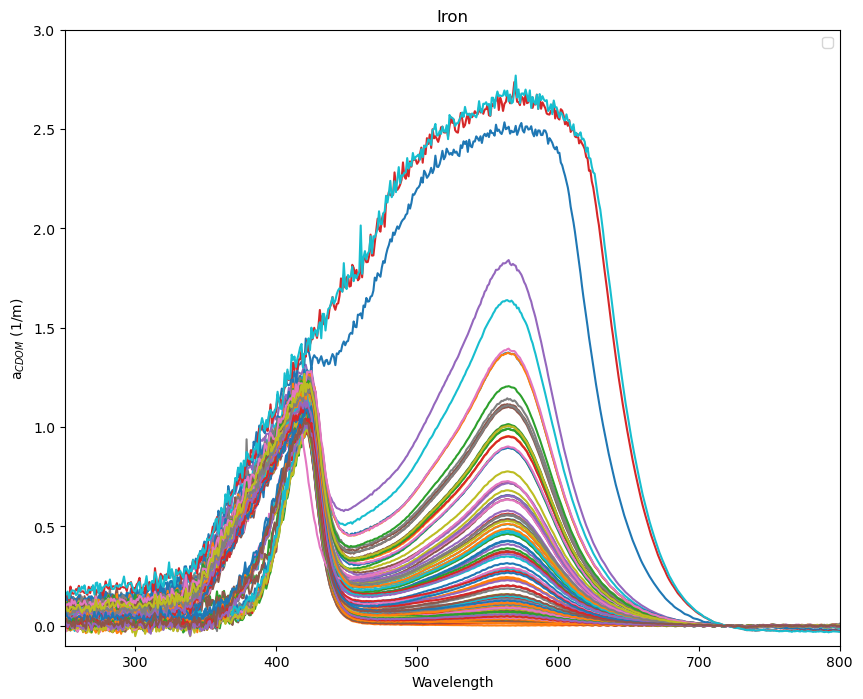

In [30]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


Text(0.5, 1.0, 'Iron')

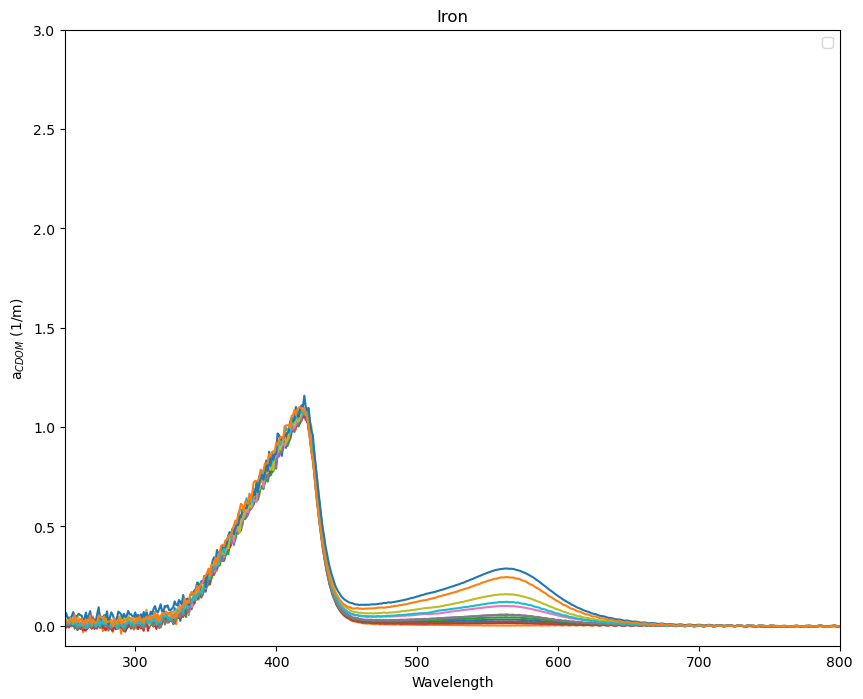

In [31]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df_nm.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("Iron")


PART 1 
THE CURVE

In [52]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.items():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('_', n=7).str[0]

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_21148\1703750503.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  inter = scipy.integrate.simps(ydata, x=xdata, even='avg')


In [53]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

std_outs.to_csv(path_save_1)

std_outs

,abs_562,intagration,conc,ID
sample,,,,
000_nm_post_Absorbance_00001.txt,0.031564,4.396330,0,000
000_nm_pre_Absorbance_00001.txt,0.001740,1.056934,0,000
010_nm_post_Absorbance_00001.txt,0.042805,5.747268,10,010
010_nm_pre_Absorbance_00001.txt,0.014143,2.357238,10,010
020_nm_post_Absorbance_00001.txt,0.054893,7.040273,20,020
020_nm_pre_Absorbance_00001.txt,0.020858,3.003290,20,020
050_nm_post_Absorbance_00001.txt,0.100099,11.975700,50,050
050_nm_pre_Absorbance_00001.txt,0.055932,6.849603,50,050
100_nm_post_Absorbance_00001.txt,0.159162,18.142797,100,100


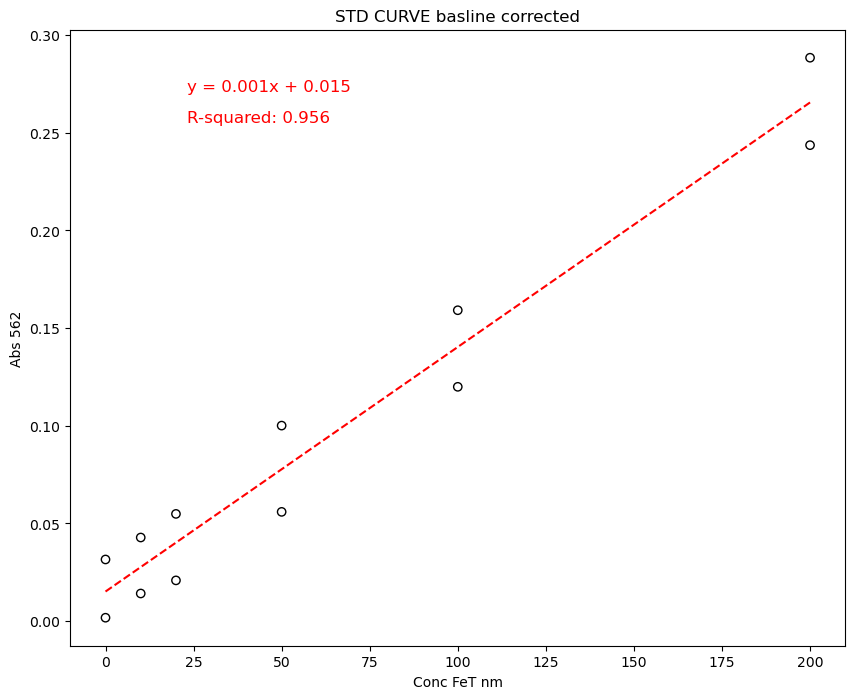

In [34]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


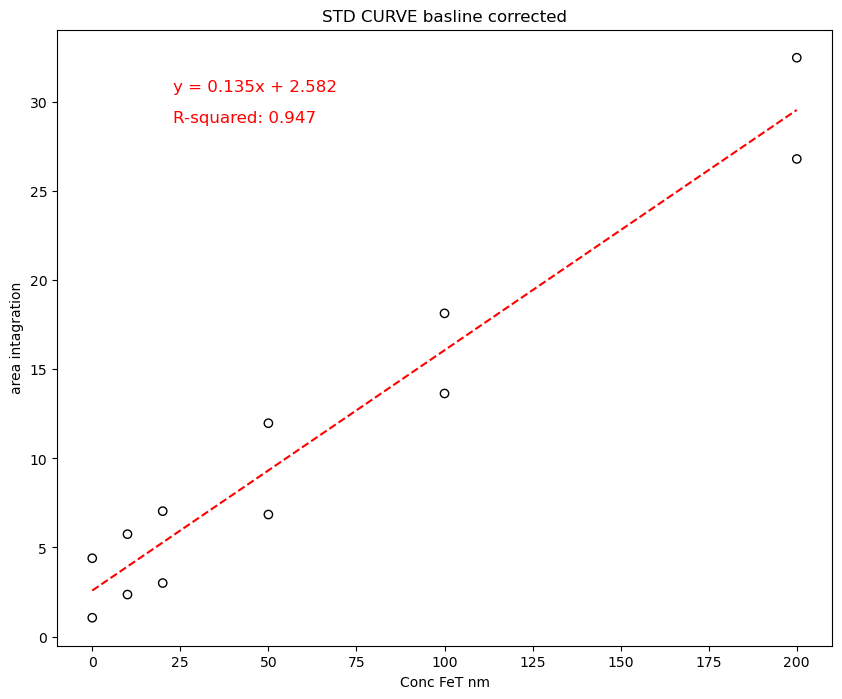

In [35]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [36]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


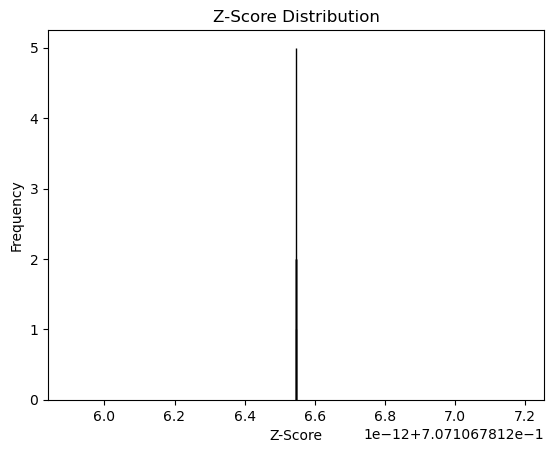

                                   abs_562  intagration  conc   ID      mean  \
sample                                                                         
010_nm_pre_Absorbance_00001.txt   0.014143     2.357238    10  010  0.028474   
020_nm_pre_Absorbance_00001.txt   0.020858     3.003290    20  020  0.037876   
100_nm_post_Absorbance_00001.txt  0.159162    18.142797   100  100  0.139558   
200_nm_pre_Absorbance_00001.txt   0.243674    26.810373   200  200  0.266056   

                                       std   z_score  
sample                                                
010_nm_pre_Absorbance_00001.txt   0.020268  0.707107  
020_nm_pre_Absorbance_00001.txt   0.024066  0.707107  
100_nm_post_Absorbance_00001.txt  0.027725  0.707107  
200_nm_pre_Absorbance_00001.txt   0.031653  0.707107  


In [37]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [39]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

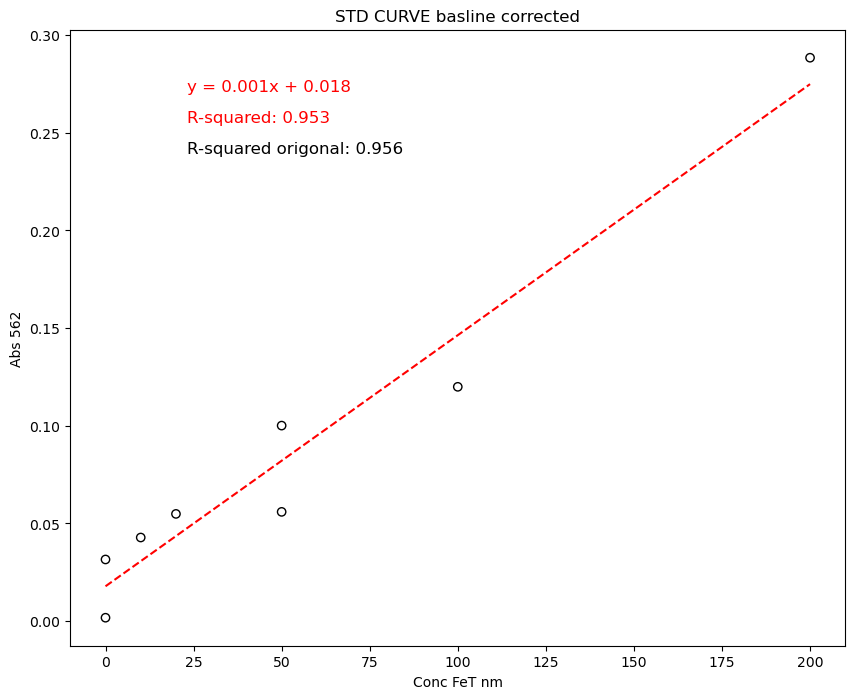

In [40]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


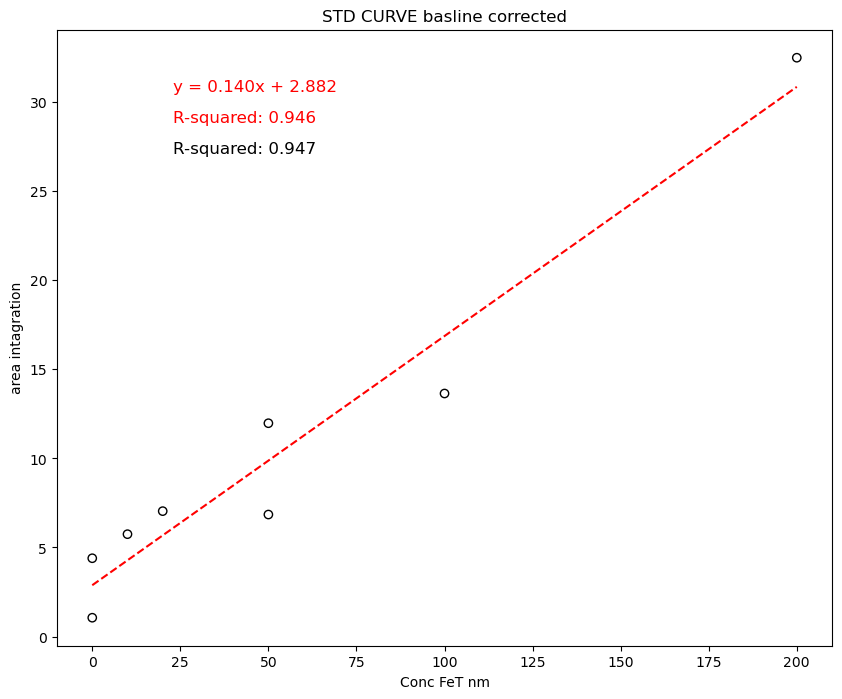

In [41]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [42]:
std_outs

,abs_562,intagration,conc,ID,mean,std,z_score
sample,,,,,,,
000_nm_post_Absorbance_00001.txt,0.031564,4.396330,0,000,0.016652,0.021088,0.707107
000_nm_pre_Absorbance_00001.txt,0.001740,1.056934,0,000,0.016652,0.021088,0.707107
010_nm_post_Absorbance_00001.txt,0.042805,5.747268,10,010,0.028474,0.020268,0.707107
020_nm_post_Absorbance_00001.txt,0.054893,7.040273,20,020,0.037876,0.024066,0.707107
050_nm_post_Absorbance_00001.txt,0.100099,11.975700,50,050,0.078016,0.031231,0.707107
050_nm_pre_Absorbance_00001.txt,0.055932,6.849603,50,050,0.078016,0.031231,0.707107
100_nm_pre_Absorbance_00001.txt,0.119954,13.643954,100,100,0.139558,0.027725,0.707107
200_nm_post_Absorbance_00001.txt,0.288438,32.493380,200,200,0.266056,0.031653,0.707107


In [43]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('ID', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs.groupby(std_outs['conc']).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

,abs_562,intagration,mean,std,z_score
conc,,,,,
0,0.016652,2.726632,0.016652,0.021088,0.707107
10,0.042805,5.747268,0.028474,0.020268,0.707107
20,0.054893,7.040273,0.037876,0.024066,0.707107
50,0.078016,9.412652,0.078016,0.031231,0.707107
100,0.119954,13.643954,0.139558,0.027725,0.707107
200,0.288438,32.493380,0.266056,0.031653,0.707107


PART 2
THE DATA

In [50]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.items():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_21148\2543233077.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  inter = scipy.integrate.simps(ydata, x=xdata, even='avg')


,abs_562,intagration
sample,,
BLANK_3_Absorbance_00001.txt,0.030422,4.525226
BLANK_3_Absorbance_00002.txt,0.032633,4.931783
BLANK_4_Absorbance_00001.txt,0.040266,5.904551
BLANK_5_Absorbance_18-02-54-628.txt,0.033460,5.114539
BLANK_6_Absorbance_00001.txt,0.041987,6.321272
...,...,...
OW_ST.P_B_Absorbance_00001.txt,0.113771,14.042357
OW_ST.P_C_Absorbance_00001.txt,0.069153,9.315043
OW_ST.P_D_Absorbance_00001.txt,0.046090,6.579713


In [51]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']
sub_outs

sub_outs.to_csv(path_save_2)


# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [46]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: BLANK
Index of row with highest z_score: 
Index(['BLANK_6_Absorbance_00001.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
BLANK_3_Absorbance_00001.txt           1.052568
BLANK_3_Absorbance_00002.txt           0.616005
BLANK_4_Absorbance_00001.txt           0.890800
BLANK_5_Absorbance_18-02-54-628.txt    0.452735
BLANK_6_Absorbance_00001.txt           1.230506
Name: z_score, dtype: float64

Group: CS
Index of row with highest z_score: 
Index(['CS_50_6_Absorbance_00001.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
CS_50_3_Absorbance_00001.txt    0.926982
CS_50_4_Absorbance_00001.txt    0.132771
CS_50_6_Absorbance_00001.txt    1.059753
Name: z_score, dtype: float64

Group: EXP
Index of row with highest z_score: 
Index(['EXP_ST.I_T3_P02F_Absorbance_00001.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
EXP_ST.D_T1_P02F_Absorbance_00001.txt    0.529566
EXP_ST.D_T1_P02F_Absorbance_00002.txt    0.524375
EXP_ST.D_

In [22]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

,abs_562,intagration,mean,std,z_score
group_name,,,,,
BLANK,0.034195,5.119025,0.035754,0.005066,0.753027
CL,0.126928,14.328693,0.126928,NaN,NaN
CS,0.095754,11.608943,0.099432,0.006941,0.529877
EXP,0.921981,113.862121,1.010601,0.679830,0.607188
EXPS,0.371053,42.958945,0.395356,0.425778,0.671345
OW,0.088430,11.401515,0.117714,0.082670,0.541723


In [23]:
XXXXXXXXXXX

NameError: name 'XXXXXXXXXXX' is not defined

In [ ]:
import pandas as pd

# Read the CSV files
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', index_col=0)
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/HANNA_IRON_RERUN_10-02-2023_RUN_2.csv', index_col=0)

# Convert the index columns of both dataframes to type object
df_meta.index = df_meta.index.astype('str')
df_iron.index = df_iron.index.astype('str')


# Pull matching values based on the index
result = df_iron.merge(df_meta[['Trip', 'Date', 'Station', 'Sample_depth']], left_index=True, right_index=True, how='left')

# Create a new DataFrame with only the desired columns in the specified order
final_df = result[['Trip', 'Date', 'Station', 'Sample_depth']]

# If you want to save this result to a new CSV:
final_df.to_csv('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/HANNA_IRON_RERUN_10-02-2023/Data_HANNA_IRON_RERUN_10-02-2023_RUN_2.csv')
final_df
